In [1]:
from sklearn.datasets import load_boston   # 波士顿房价数据，回归使用

In [2]:
# 读取boston房价数据集
boston = load_boston()
data = boston.data
target = boston.target

print(data.shape) # 输出：(506, 13)
print(target.shape) # 输出： (506,)

(506, 13)
(506,)


In [9]:
# 划分成训练集和测试集
from sklearn.model_selection import train_test_split
X_train,X_test, y_train, y_test = train_test_split(data,target,test_size=0.2, random_state=0)

In [39]:
# XGB回归
from xgboost import XGBRegressor   # 用xgb回归
xgb = XGBRegressor(n_estimators=50, max_depth=5)

In [40]:
# 训练
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=50, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [55]:
# 预测
result = xgb.predict(X_test)
error = result - y_test
print("error:", abs(error).mean())
print("variance:", abs(error).std())

error: 2.948908808652092
variance: 3.8929505734240366


In [56]:
# shap分析
import shap
shap.initjs()  # notebook环境下，加载用于可视化的JS代码

在SHAP中进行模型解释需要先创建一个explainer，SHAP支持很多类型的explainer  
SHAP库可用的explainers有：
* deep：用于计算深度学习模型，基于DeepLIFT算法
* gradient：用于深度学习模型，综合了SHAP、集成梯度、和SmoothGrad等思想，形成单一期望值方程
* kernel：模型无关，适用于任何模型
* linear：适用于特征独立不相关的线性模型
* tree：适用于树模型和基于树模型的集成算法
* sampling ：基于特征独立性假设，当你想使用的后台数据集很大时，kenel的一个很好的替代方案

In [60]:
# 建立一个explainer
explainer = shap.TreeExplainer(xgb)
# 传入特征矩阵X，计算SHAP值
shap_values = explainer.shap_values(X_test)

In [65]:
shap_values[0,:]

array([ 0.04592935,  0.09422947,  0.792294  , -0.02760627,  0.18834414,
       -2.3927648 ,  0.5242159 , -0.10601954, -0.02181356, -0.7474397 ,
        0.8125316 ,  0.21085288,  3.151611  ], dtype=float32)

In [64]:
# 单个实例的可视化
shap.force_plot(explainer.expected_value,  # label的均值
                shap_values[0,:],   # SHAP值
                X_test[0,:],    # 特征取值
                feature_names=boston.feature_names)

In [67]:
# 对多个实例的可视化
shap.force_plot(explainer.expected_value, shap_values, X_test)

summary plot 为每个样本绘制其每个特征的SHAP值，这可以更好地理解整体模式，并允许发现预测异常值。  
每一行代表一个特征，横坐标为SHAP值。一个点代表一个样本，颜色表示特征值(红色高，蓝色低)。  
比如，这张图表明LSTAT特征较高的取值会降低预测的房价

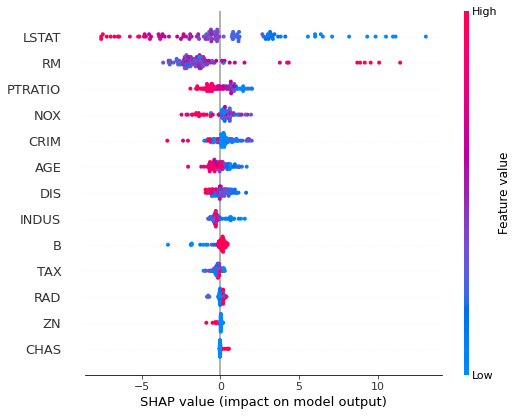

In [62]:
# 可视化第一个prediction的解释   如果不想用JS,传入matplotlib=True
shap.summary_plot(shap_values, X_test, feature_names=boston.feature_names)

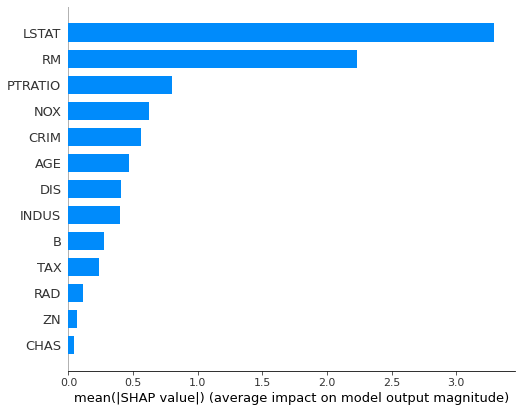

In [70]:
# 取每个特征的SHAP值的绝对值的平均值作为该特征的重要性，得到一个标准的条形图(multi-class则生成堆叠的条形图)
shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=boston.feature_names)